In [1]:
!pip install unzip

In [2]:
!unzip tennis_court_det_dataset.zip

Archive:  tennis_court_det_dataset.zip
   creating: data/
  inflating: data/data_train.json    
  inflating: data/data_val.json      
   creating: data/images/
  inflating: data/images/-0M6ixK7aIU_1050.png  
  inflating: data/images/-0M6ixK7aIU_1100.png  
  inflating: data/images/-0M6ixK7aIU_1150.png  
  inflating: data/images/-0M6ixK7aIU_1200.png  
  inflating: data/images/-0M6ixK7aIU_1250.png  
  inflating: data/images/-0M6ixK7aIU_1300.png  
  inflating: data/images/-0M6ixK7aIU_1350.png  
  inflating: data/images/-0M6ixK7aIU_1500.png  
  inflating: data/images/-0M6ixK7aIU_1550.png  
  inflating: data/images/-0M6ixK7aIU_1600.png  
  inflating: data/images/-0M6ixK7aIU_1650.png  
  inflating: data/images/-0M6ixK7aIU_1700.png  
  inflating: data/images/-0M6ixK7aIU_1900.png  
  inflating: data/images/-0M6ixK7aIU_1950.png  
  inflating: data/images/-0M6ixK7aIU_2000.png  
  inflating: data/images/-0M6ixK7aIU_2050.png  
  inflating: data/images/-0M6ixK7aIU_2100.png  
  inflating: data/images

Info sur les données, le premier fichier est un fichier json qui contient les informations sur les images et les keypoints donc la ground truth.
On a donc le x et le y de chaque keypoints.

Start code

In [16]:
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, models

import json

import cv2

import numpy as np


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
#create a torch dataset
class KeypointsDataset(Dataset): 
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        #load the data file avec json pcq le fichier json est une forme de dictionnaire.
        with open(data_file,"r") as f:
            self.data = json.load(f)
        
        #transformations to be applied on the images ça va rendre les images à la même taille et les normaliser.
        self.transforms = transforms.Compose([#liste de transformations que l'on veut appliquer sur les images
            transforms.ToPILImage(), #convert the image to a PIL Image 
            transforms.Resize((224,224)), #resize the image to 224x224 pixels afin de ne pas perdre d'information que ce soit par exemple du 64 par 64.
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], #normalize the image ainsi les valeurs des pixels sont entre 0 et 1 et donc plus simplpe à entraîner.
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self): # donne la longueur du dataset
        return len(self.data)

    def __getitem__(self, idx): #donne un élément du dataset donc pour avec les items batch par batch. Prends en paramètre l'index de l'élément que l'on veut et retourne l'image et les keypoints.
        item = self.data[idx]
        img = cv2.imread(f"{self.img_dir}/{item['id']}.png") #lecture de l'image
        h,w = img.shape[:2]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convertir l'image en RGB
        img = self.transforms(img) #appliquer les transformations sur l'image
        kps = np.array(item['kps']).flatten() #récupérer les keypoints
        kps = kps.astype(np.float32) #convertir les keypoints en float32
        kps[::2] *= 224.0 /w #Ajuster les x des keypoints pcq on change la taille de l'image en 224 alors que c'était par exemple w avant.
        kps[1::2] *= 224.0 /h #Ajuster les y des keypoints pcq on change la taille de l'image en 224 alors que c'était par exemple h avant.
        return img, kps

Spécification des proportions des données d'entraînement et de test. 

In [19]:
train_dataset = KeypointsDataset("data/images","data/data_train.json")
val_dataset = KeypointsDataset("data/images","data/data_val.json")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

Create a model

In [20]:
model = models.resnet50(pretrained=True) #utiliser un modèle pré-entraîné resnet qui c'est entraîné sur d'autres images, permet de download le model, mais resnet50 n'est pas entraîné pour extraire les keypoints donc on aura besoin de freeze la dernière layer pour représenter nos besoins et ajouter une layer pour les keypoints.

model.fc = torch.nn.Linear(model.fc.in_features, 14*2) # fully connected layer qui est la dernière layer du modèle, on change le nombre de sortie pour avoir 14 keypoints avec x et y donc 14*2.

C:\Users\ggyor\anaconda3\envs\yolov5\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ggyor\anaconda3\envs\yolov5\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
model = model.to(device) # moove le model to cuda ou cpu

Training le modèle

Définir la loss fonction et l'optimizer

In [22]:
criterion = torch.nn.MSELoss() #Mean Squared Error Loss pour comparer les keypoints prédits et les keypoints réels.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #Adam optimizer pour mettre à jour les poids du modèle, utilisant ADAM avec un learning rage de 1e-4.


In [23]:
epochs = 20
losses = []
for epoch in range(epochs):
    lossInEpoch = 0
    step = 0
    for i, (imgs, kps) in enumerate(train_loader):#le train loader permet de retourner à chaque fois le batch d'images et de keypoints
        imgs = imgs.to(device)
        kps = kps.to(device)

        optimizer.zero_grad() #mettre à zéro les gradients pour ne pas les accumuler
        outputs = model(imgs) #faire une prédiction des keypoints sur les images données par le modèle
        loss = criterion(outputs, kps) #calculer la loss entre les keypoints prédits et les keypoints réels
        loss.backward() # barckward propagation 
        optimizer.step() #mettre à jour les poids du modèle
    
        if i % 10 == 0:
            print(f"Epoch {epoch}, step {i}, loss {loss.item()}")
            lossInEpoch += loss.item()
            print(lossInEpoch)
            step += 1
    losses.append(lossInEpoch/step)
    print(lossInEpoch/step)
    

Epoch 0, step 0, loss 15623.9716796875
15623.9716796875
Epoch 0, step 10, loss 14262.6123046875
29886.583984375
Epoch 0, step 20, loss 14368.705078125
44255.2890625
Epoch 0, step 30, loss 14034.6708984375
58289.9599609375
Epoch 0, step 40, loss 13974.7666015625
72264.7265625
Epoch 0, step 50, loss 13187.9384765625
85452.6650390625
Epoch 0, step 60, loss 12342.794921875
97795.4599609375
Epoch 0, step 70, loss 11979.2685546875
109774.728515625
Epoch 0, step 80, loss 13027.0107421875
122801.7392578125
Epoch 0, step 90, loss 10938.826171875
133740.5654296875
Epoch 0, step 100, loss 10885.001953125
144625.5673828125
Epoch 0, step 110, loss 11481.52734375
156107.0947265625
Epoch 0, step 120, loss 10266.3359375
166373.4306640625
Epoch 0, step 130, loss 9612.4814453125
175985.912109375
Epoch 0, step 140, loss 9700.7685546875
185686.6806640625
Epoch 0, step 150, loss 9296.171875
194982.8525390625
Epoch 0, step 160, loss 8956.0068359375
203938.859375
Epoch 0, step 170, loss 8387.041015625
212325

In [24]:
torch.save(model.state_dict(), "keypoints_model_3.pth") #sauvegarder le modèle

[4757.776477859681, 83.82927138546863, 45.0772779763463, 37.80239227593663, 17.770579886723713, 12.963726391275245, 11.827101275145289, 8.661269373204334, 6.4093465359814195, 10.622295077306678, 6.555230970124164, 4.4790550951498105, 7.266383799443762, 4.56756685979395, 5.9268026366291275, 8.35474713272359, 2.9151395857334137, 4.96093778114721, 1.4657603739255882, 6.923085022583066]


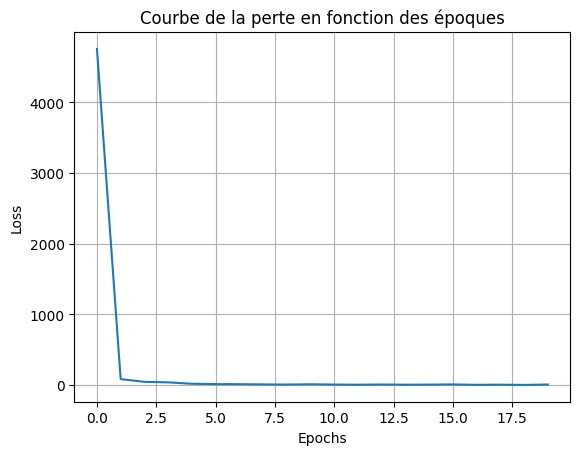

In [30]:
# print the loss through all the epochs  
import matplotlib.pyplot as plt
print(losses)
# plot the loss in function to the epochs
plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte en fonction des époques')
plt.grid()
plt.show()
